# Q1: Theoretical Questions

1. Briefly explain the differences between following models:
* FVSBN
* NADE
* RNADE
* PixelRNN
* PixelCNN

----

2. Briefly explain the relationships between following concepts:
* Neg-log-likelihood
* Max-likelihood-estimation
* Cross-entropy-loss
* KL-divergence

---

3. True/False questions
* $D(p || q)$ is equal to $D(q || p)$
* Autoregressive models tries to learn a data distribution in an explicit manner.
* In PixelCNN masking applies only to previous pixels.

# Q2: *Fully Visible Sigmoid Belief Networks*
In this part, first we are going to implement the evaluation function for the FVSBN. Afterwards we are going to implement a function for sampling purposes.

Suppose that we have a dataset which contains handwritten digit images. Each image consist of 28x28 black-or-white pixels (binarised MNIST). 
Our goal is learning a probabilty distribution $p(x) = p(x_1, x_2, \dots , x_{784})$ such that when we sample an instance from that distribution it should look like a digit.

In autoregressive models, we are binding each pixel (variable) conditionally and sequentially (left-to-right etc.). 
$p(x_1, x_2, \dots , x_{784}) = p(x_1)p(x_2|x_1)p(x_3|x_1, x_2) \dots p(x_{784}|x_1, x_2 \dots, x_{783})$


In Fully Visible Sigmoid Belief Networks, we assume;

$p(x_i = 1 | x_1, x_2 \dots, x_{i-1}) = \sigma(\alpha^{(i)}_0 + \sum_{h=1}^{i-1} \alpha^{(i)}_h x_h)$

Where $\sigma$ denotes the sigmoid function and $\alpha$ denotes the learnable parameters.

Every i'th pixel have parameter for all the previous pixels and also a bias term, so that the model have $1+2+\dots+784$ parameters.

In the coding part, a denotes the $\alpha$ and it is a [lower triangular matrix](https://wikimedia.org/api/rest_v1/media/math/render/svg/f770c7fa4c212eac3d7d7f9a54f7decbc811276f)


In [ ]:
import numpy as np

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def evaluate(a, x):
  # args:
  #   a -> paramaters np.array(784, 784)
  #   x -> image sample np.array(1, 784)

  # return:
  #   a floating point number that denotes the p(x)


  ################################# solution ################################# 

  # "a" is a lower triangular matrix:
  #  [[1., 0., 0., 0.],
  #   [1., 1., 0., 0.],
  #   [1., 1., 1., 0.],
  #   [1., 1., 1., 1.]]

  # since "Every i'th pixel have parameter for all the previous
  #        pixels and also a bias term, so that the model have 
  #        1+2+ ... +784 parameters." 
  # the first column denotes the bias term, lets split the bias first
  b = a[:,0]    # [784]
  w = a[:,1:]   # [784, 783]

  # since "Every i'th pixel have parameter for all the previous pixels ..."
  # we don't have any parameter for the last pixel
  x = x[0,:-1]  # [783]

  z = np.matmul(w, x) + b
  p_i = sigmoid(z)

  # finally multiply all the i'th probabilities
  p = np.prod(p_i)

  ############################################################################

  return p


def sample(a):
  # args:
  #   a -> paramaters (784, 784)

  # return:
  #   a numpy array in the shape of (28x28)


  ################################# solution ################################# 
  image = np.zeros([784])
  
  b = a[:,0]    # [784]
  w = a[:,1:]   # [784, 783]

  for i in range(1, 783):
    p_i = sigmoid(b[i] + np.matmul(w[i,:], image[:-1]))
    image[i] = np.random.choice([1,0], p=[p_i, 1-p_i])

  image = np.reshape(image, [28,28])
  ############################################################################

  return image


# Q3: *Kullback–Leibler Divergence*
In this part we are going to implement a function for calculating the KL divergence between given two Gaussians.

For the math part, [this](https://mr-easy.github.io/2020-04-16-kl-divergence-between-2-gaussian-distributions/) link might help.

In [ ]:
import numpy as np

def gaussian_probability_density(x, mean, std_dev):
  return 1 / (std_dev * np.sqrt(2 * np.pi)) * np.exp(-1 * (x - mean)**2 / (2 * std_dev**2))

def kl_divergence(p, q):
  # args:
  #   p -> gaussian-1, tupple(mean, std)
  #   q -> gaussian-2, tupple(mean, std)

  # return:
  #   a floating point number that denotes D(p||q)

  p_dist = np.random.normal(p[0], p[1], 1000)
  q_dist = np.random.normal(q[0], q[1], 1000)


  ##### solution #####
  p = gaussian_pdf(p_dist, p[0], p[1])
  q = gaussian_pdf(q_dist, q[0], q[1])
  d = np.sum(p * np.maximum(np.log(p / q), 0))
  ####################

  return d


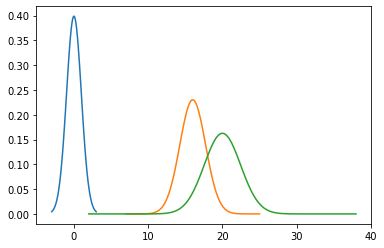

In [ ]:
# Test
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

p = (0, 1)
q = (16, 3)
y = (20, 6)

pl = np.linspace(p[0] - 3*p[1], p[0] + 3*p[1], 100)
ql = np.linspace(q[0] - 3*q[1], q[0] + 3*q[1], 100)
yl = np.linspace(y[0] - 3*y[1], y[0] + 3*y[1], 100)

plt.plot(pl, stats.norm.pdf(pl, p[0], math.sqrt(p[1])))
plt.plot(ql, stats.norm.pdf(ql, q[0], math.sqrt(q[1])))
plt.plot(yl, stats.norm.pdf(yl, y[0], math.sqrt(y[1])))
plt.show()

In [ ]:
# After uncommenting below lines, please run your implementation and observe it

D_pq = kl_divergence(p, q)
D_qp = kl_divergence(q, p)
D_py = kl_divergence(p, y)
D_yq = kl_divergence(y, q)


In [ ]:
D_pq, D_qp, D_py, D_yq

(388.1094152035839, 7.45238393725293, 565.8057688445564, 6.381930027732736)

# Q4: *PixelCNN*
In this part we are going to implement the masking and the generation parts for a very simplified version of the PixelCNN.

The model consist of one convolutional layer and fully-connected layer. Assume that inputs are 28x28 grayscale (0 to 255) images.

You should first apply a masking strategy for 7x7 kernels.

Then you should autoregressively (pixel by pixel) generate the image by passing each pixel to network.

In [ ]:
image_size = 28
KERNEL_SIZE = 7
FILTER_NUM = 64
STRIDE = 1
PADDING = KERNEL_SIZE//2
OUT = 256

sample_img = np.zeros([image_size, image_size])

filters = np.random.randn(KERNEL_SIZE, KERNEL_SIZE, FILTER_NUM)
bias = np.random.randn(FILTER_NUM)
fully_connected = np.random.randn(FILTER_NUM, OUT)

############## SOLUTION ##############


########## masking ###########
filters[KERNEL_SIZE//2:,KERNEL_SIZE//2:, :] = 0
filters[KERNEL_SIZE//2+1:,:,:] = 0
####### end of masking #######



######### generation ##########

img_padded = np.pad(sample_img, KERNEL_SIZE//2, mode='constant')

for i in range(image_size):
  for j in range(image_size):
    img_slice = img_padded[i:i+KERNEL_SIZE, j:j+KERNEL_SIZE]
    feats = np.tensordot(img_slice, filters) + bias # [64]
    outs = np.matmul(feats, fully_connected) # [256]
    probs = outs/np.sum(outs) # 256
    img_padded[(KERNEL_SIZE//2) + i, (KERNEL_SIZE//2) + j] = np.argmax(probs)

img = img_padded[KERNEL_SIZE//2:-(KERNEL_SIZE//2),KERNEL_SIZE//2:-(KERNEL_SIZE//2)]
###### end of generation ######

########### END OF SOLUTION ###########



(28, 28)

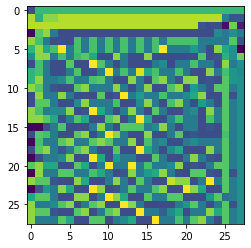

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img)